# Imports

In [1]:
#Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm



from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold


# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv


# Sparse vector
from sparse_vector.sparse_vector import SparseVector

In [2]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Data loading

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features]

In [4]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'z_dna/hg38_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"z_dna/hg38_dna/{file}") for file in files])

In [5]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]

CPU times: user 1min 24s, sys: 4.04 s, total: 1min 28s
Wall time: 1min 28s


In [6]:
print(len(DNA_features))

1946


# Data selection 

In [7]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals, lrp_feat=[]):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        self.lrp_feat = lrp_feat

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        if len(self.lrp_feat) > 0:
            X = X[:,np.sort(lrp_feat)]

        return (X, y)



In [8]:
width = 100

np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]

100%|██████████████████████████████████████| 165/165 [00:00<00:00, 48538.38it/s]


In [9]:

used_memory = torch.cuda.memory_allocated()

free_memory = torch.cuda.memory_reserved() - used_memory

print(f"Используемая память: {used_memory / (1024 ** 2)} MB")
print(f"Свободная память: {free_memory / (1024 ** 2)} MB")

Используемая память: 0.0 MB
Свободная память: 0.0 MB


In [10]:
np.random.seed(42)
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                                 for i, elem
                                                                 in enumerate(equalized)]))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

In [11]:
params = {'batch_size':16,
          'num_workers':4,
          'shuffle':True}

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

In [12]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, recall_score
from IPython.display import clear_output
import time

In [13]:
#CNN model
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
                    nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(3),
                    nn.ReLU(),
                    nn.Conv2d(3, 3, kernel_size=(5, 5), padding=2),
                    nn.ReLU(),
                    nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(1),
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.Linear(1950, 500),
                    nn.Dropout(0.25),
                    nn.ReLU(),
                    nn.Linear(500, 2)
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, 1950)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

# Train and test

In [37]:
def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(torch.transpose(output, 2, 1), y_batch)



def train_epoch(model, optimizer):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.train()
    for X_batch, y_batch in loader_train:
        device = torch.device('cuda:0')
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
        #X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        optimizer.zero_grad()
        output = model(X_batch)
        if output.dim() == 2:  
            output = output.unsqueeze(0)  
        pred = torch.argmax(output, dim=2)
        with torch.no_grad():
            y_pred = nn.Softmax(dim=1)(output)[:, :,1].cpu().numpy().flatten()
            if np.std(y_batch.cpu().numpy().flatten()) == 0:
                roc_auc = 0
            else:
                roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                        y_pred)
            f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                             pred.cpu().numpy().flatten(), zero_division=0))

        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred.to(device) == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        loss_log.append(loss)
        torch.cuda.empty_cache()
    return loss_log, acc_log, roc_auc_log, f1_log

def test(model):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.eval()
    means = []
    with torch.no_grad():
        for X_batch, y_batch in loader_test:
            device = torch.device('cuda:0')
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
            #X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
            output = model(X_batch)

            if output.dim() == 2:  
                output = output.unsqueeze(0)  
            means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
            pred = torch.argmax(output, dim=2)
            if np.std(y_batch.cpu().numpy().flatten()) == 0:
                roc_auc = 0
            else:
                roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                        nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())

            f1 = f1_score(y_batch.cpu().numpy().flatten(),
                                      pred.cpu().numpy().flatten(), zero_division=0)
            if f1 == 0.0 and torch.all(y_batch == 0) and torch.all(pred == 0):
                pass
            else:
                f1_log.append(f1)
            roc_auc_log.append(roc_auc)
            acc = torch.mean((pred.to(device) == y_batch).float())
            acc_log.append(acc.cpu().numpy())
            loss = loss_func(output, y_batch)
            loss_log.append(loss.item())
            torch.cuda.empty_cache()
    return loss_log, acc_log, roc_auc_log, f1_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log, train_auc_log, train_f1_log = [], [], [], []
    val_log,   val_acc_log,   val_auc_log, val_f1_log   = [], [], [], []
    times = []
    best_models = []
    for epoch in range(n_epochs):
        start_time = time.time()
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_loss, train_acc, train_auc, train_f1 = train_epoch(model, opt)
        val_loss, val_acc, val_auc, val_f1 = test(model)
        best_models.append(deepcopy(model))
        
        end_time = time.time()
        times.append(end_time - start_time)
        BatchSize = len(train_loss)
        
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_auc_log.extend(train_auc)
        train_f1_log.extend(train_f1)

        val_log.append(np.mean(val_loss))
        val_acc_log.append(np.mean(val_acc))
        val_auc_log.append(np.mean(val_auc))
        val_f1_log.append(np.mean(val_f1))
        
#         raise BaseException
        
        if (epoch % 1) == 0:
            clear_output()
            plot_history(train_log,     val_log,     'Loss',     BatchSize)    
            plot_history(train_acc_log, val_acc_log, 'Accuracy', BatchSize)
            plot_history(train_auc_log, val_auc_log, 'Auc',      BatchSize)
            plot_history(train_f1_log, val_f1_log,   'F1',       BatchSize)
            print("Epoch {} AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
            print("Epoch {} accuracy = {:.2%}".format(epoch+1, val_acc_log[-1]))
            print("Epoch {} F1 = {:.2%}".format(epoch+1, val_f1_log[-1]))
            
           
    print("Final AUC: {:.2%}".format(val_auc_log[-1]))
    print("Final F1: {:.2%}".format(val_f1_log[-1]))
    print("Final Accuracy: {:.2%}".format(val_acc_log[-1]))
    return val_auc_log, val_f1_log, val_acc_log, times, best_models
    


In [12]:
set_random_seed(42)
torch.cuda.empty_cache()
model = DeepCNN()
model = model.cuda()
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)



NameError: name 'DeepCNN' is not defined

In [26]:
import sys
import logging

nblog = open("nb_cnn.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


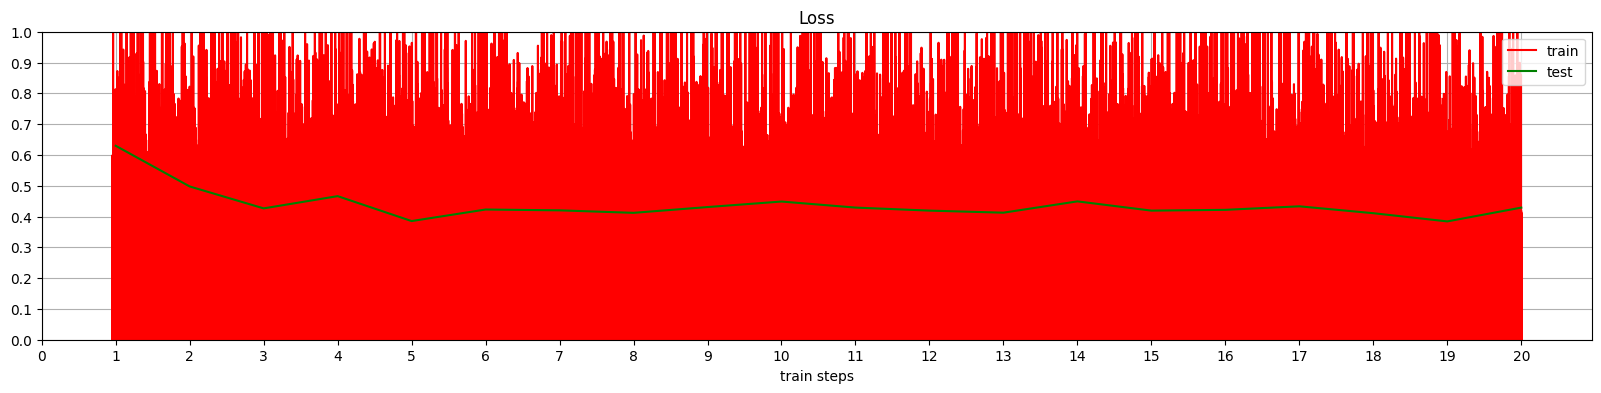

NameError: name 'version' is not defined

In [27]:
val_auc_log, val_f1_log, val_acc_log= train(model, opt, 20)


In [28]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f}".format(np.mean(times)))

NameError: name 'val_f1_log' is not defined

# Без дропаута

In [97]:
#CNN model
class DeepCNN_without_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
                    nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(3),
                    nn.ReLU(),
                    nn.Conv2d(3, 3, kernel_size=(5, 5), padding=2),
                    nn.ReLU(),
                    nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(1),
                    nn.ReLU(),
                    #nn.Dropout(0.25),
                    nn.Linear(1950, 500),
                    #nn.Dropout(0.25),
                    nn.ReLU(),
                    nn.Linear(500, 2)
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, 1950)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [43]:
import sys
import logging

nblog = open("nb_cnn_without_dropout.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [45]:
set_random_seed(42)
torch.cuda.empty_cache()
model = DeepCNN_without_dropout()
model = model.cuda()
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)



In [ ]:
val_auc_log, val_f1_log, val_acc_log = train(model, opt, 20)


Epoch 1 of 20


In [47]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f}".format(np.mean(times)))

NameError: name 'val_f1_log' is not defined

# Alpha Dropout

In [68]:
class DeepCNN_with_alpha_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
                    nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(3),
                    nn.SELU(),
                    nn.Conv2d(3, 3, kernel_size=(5, 5), padding=2),
                    nn.SELU(),
                    nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(1),
                    nn.SELU(),
                    nn.AlphaDropout(p=0.2, inplace=False),
                    nn.Linear(1950, 500),
                    nn.AlphaDropout(p=0.2, inplace=False),
                    nn.SELU(),
                    nn.Linear(500, 2)
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, 1950)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [72]:
import sys
import logging

nblog = open("nb_cnn_with_alpha_dropout.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [73]:
set_random_seed(42)
torch.cuda.empty_cache()
model = DeepCNN_with_alpha_dropout()
model = model.cuda()
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)



In [ ]:
val_auc_log, val_f1_log, val_acc_log, times = train(model, opt, 20)

Epoch 1 of 20


In [ ]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f}".format(np.mean(times)))

# batch size 1

In [77]:
#CNN model
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
                    nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(3),
                    nn.ReLU(),
                    nn.Conv2d(3, 3, kernel_size=(5, 5), padding=2),
                    nn.ReLU(),
                    nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(1),
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.Linear(1950, 500),
                    nn.Dropout(0.25),
                    nn.ReLU(),
                    nn.Linear(500, 2)
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, 1950)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [79]:
import sys
import logging

nblog = open("nb_cnn_with_batch_size_1.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [80]:
set_random_seed(42)
torch.cuda.empty_cache()
model = DeepCNN()
model = model.cuda()
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)



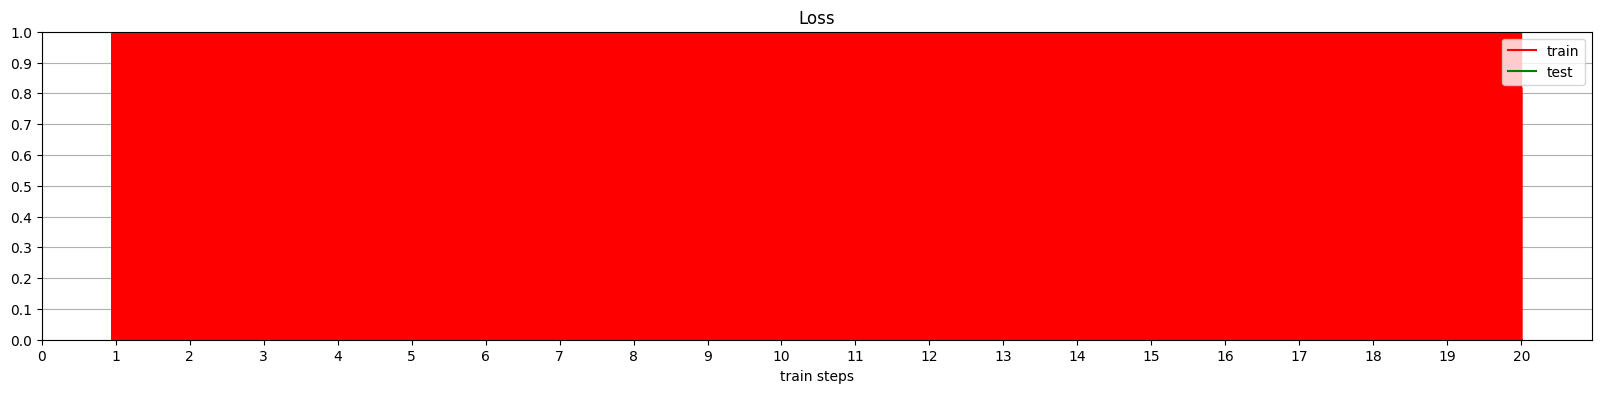

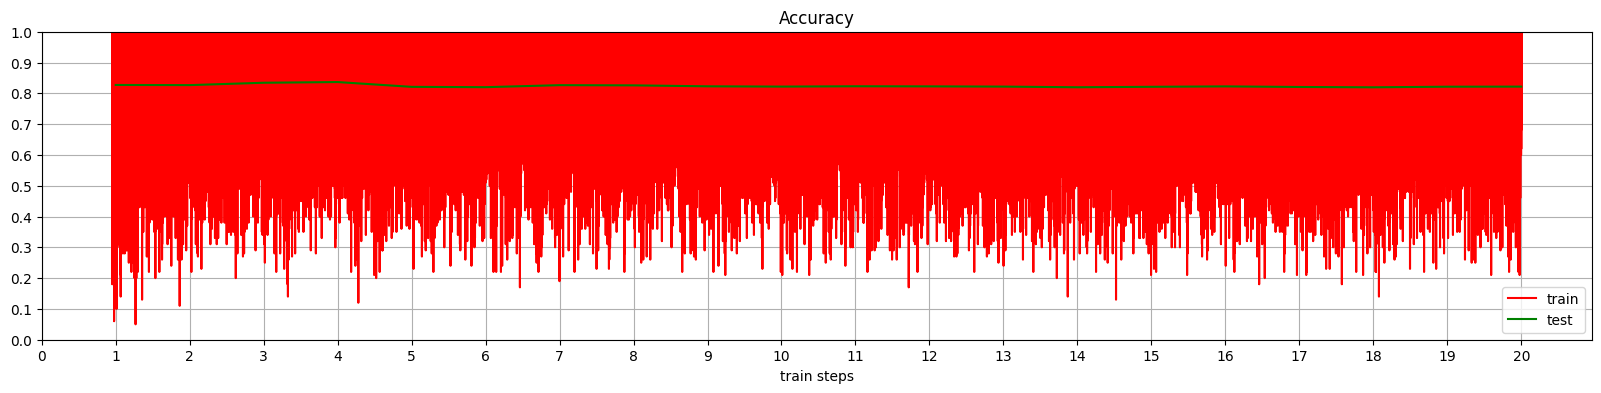

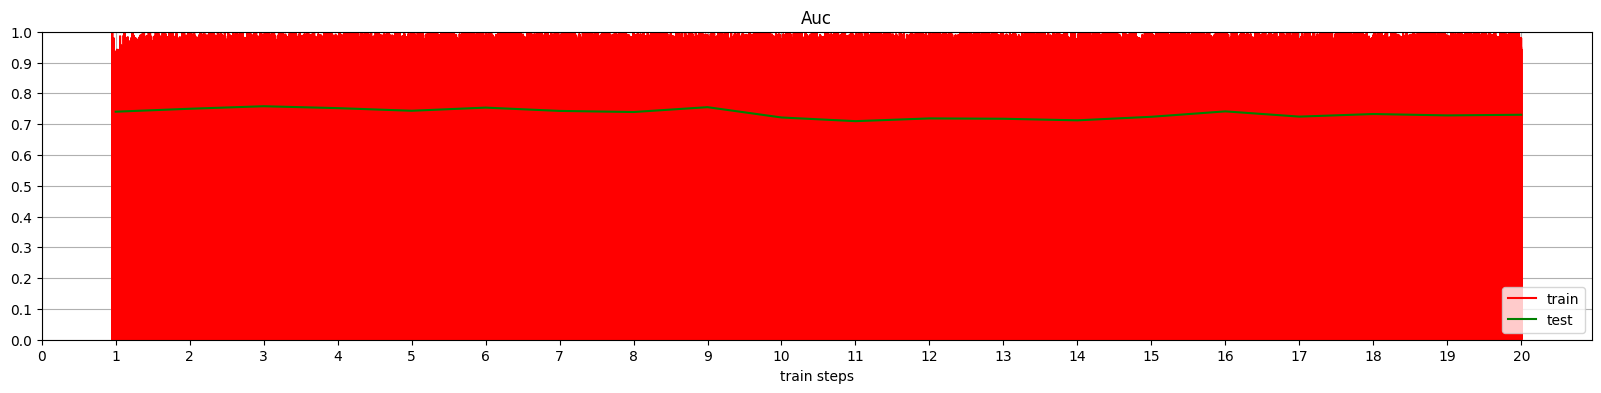

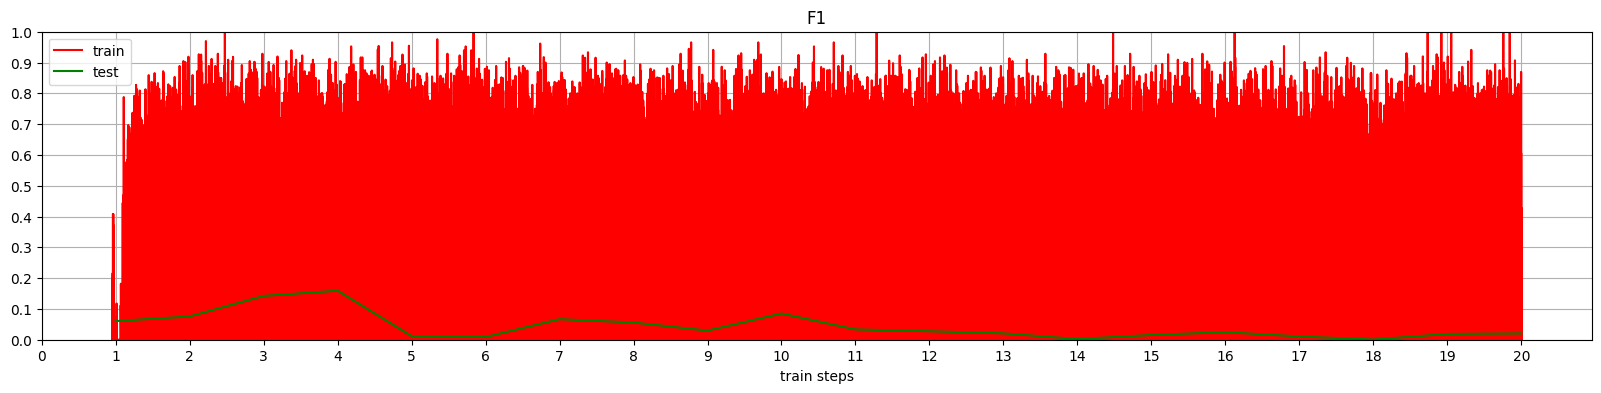

Epoch 20 AUC = 73.04%
Epoch 20 accuracy = 82.18%
Epoch 20 F1 = 2.05%
Final AUC: 73.04%
Final F1: 2.05%
Final Accuracy: 82.18%


In [81]:
val_auc_log, val_f1_log, val_acc_log, times = train(model, opt, 20)

In [82]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f}".format(np.mean(times)))

Epoch 3
Max F1-score: 0.1593
ROC-AUC: 0.7519
Mean time for 1 epoch 3704.54


# A really, really big model

In [34]:
class DeepCNN_12_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(2, 4),


            nn.Conv2d(4, 8, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(4, 8),
 

            nn.Conv2d(8, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, 16),


            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 32),


            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 64), 

            nn.Conv2d(64, 128, kernel_size=(5, 5), padding=2),
            nn.ReLU(),
            nn.GroupNorm(32, 128),  


            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1),  
            nn.ReLU(),
            nn.GroupNorm(32, 64),  


            
            nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 32),  


            nn.Conv2d(32, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, 16), 


            nn.Conv2d(16, 8, kernel_size=(3, 3), padding=1),  
            nn.ReLU(),
            nn.GroupNorm(4, 8),  


            nn.Conv2d(8, 4, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(4, 4),  


            nn.Conv2d(4, 1, kernel_size=(3, 3), padding=1),  
            nn.ReLU(),
            nn.GroupNorm(1, 1), 


            
            nn.AlphaDropout(p = 0.2),
            nn.Linear(1950, 500),
            nn.AlphaDropout(p = 0.2),
            nn.SELU(),
            nn.Linear(500, 2)
    )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, 1950)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x


In [28]:
from copy import deepcopy

In [29]:
import sys
import logging

nblog = open("nb_cnn_with_12_layers_v2.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [30]:
import gc

gc.collect()

1498

In [31]:
torch.cuda.empty_cache()

In [38]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device('cuda:0')
# device_ids = [1, 3]
with torch.cuda.device(device):
    model = DeepCNN_12_layers()
# model= nn.DataParallel(model, device_ids=device_ids)
# model.to(f'cuda:{device_ids[0]}')
    model = model.to(device)
#model = model.cuda()
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)


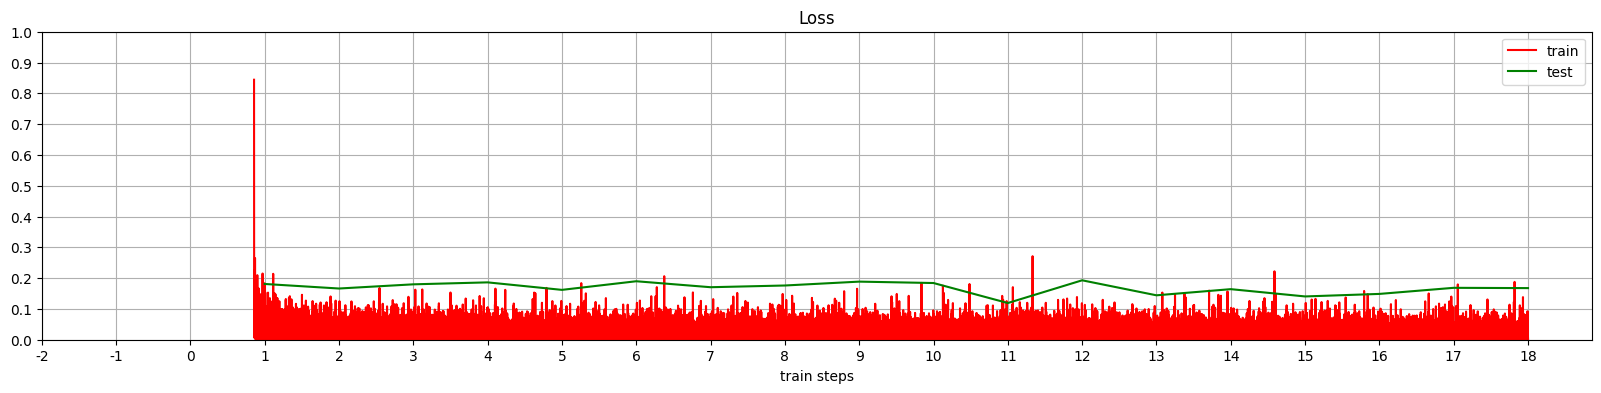

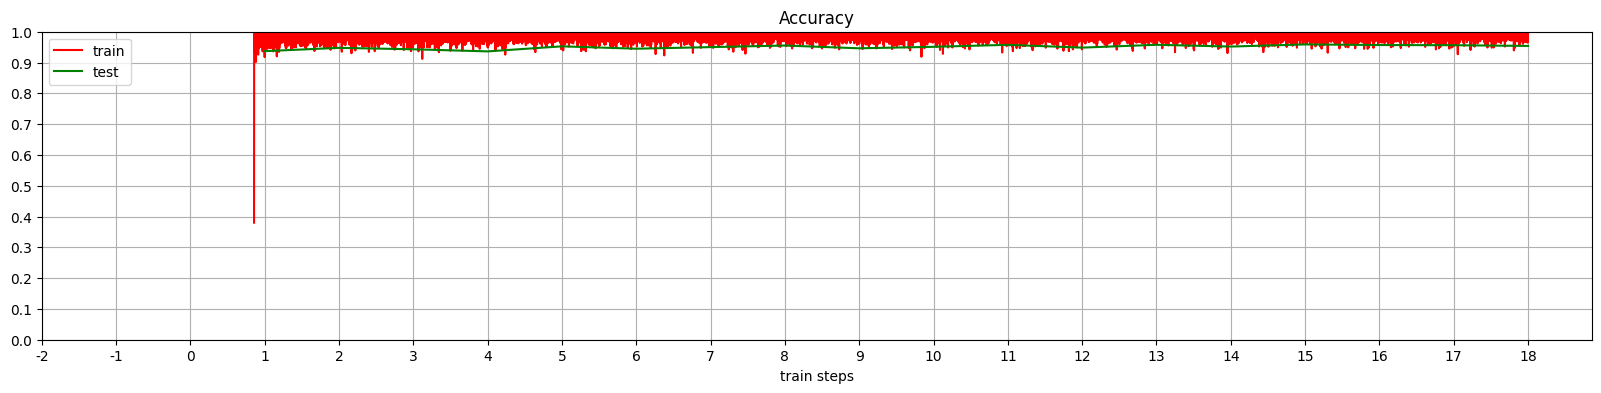

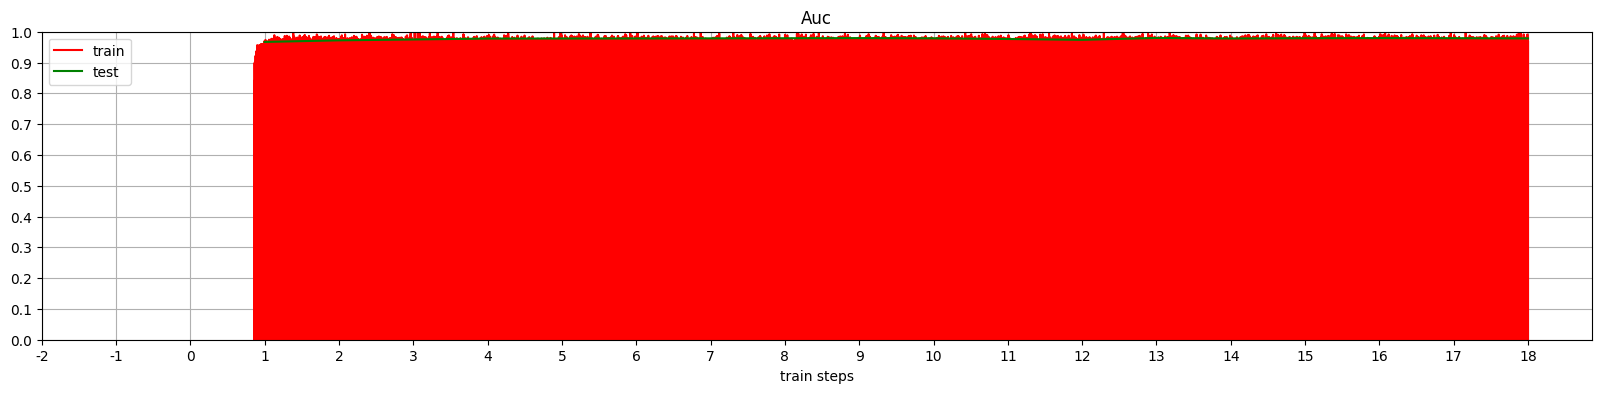

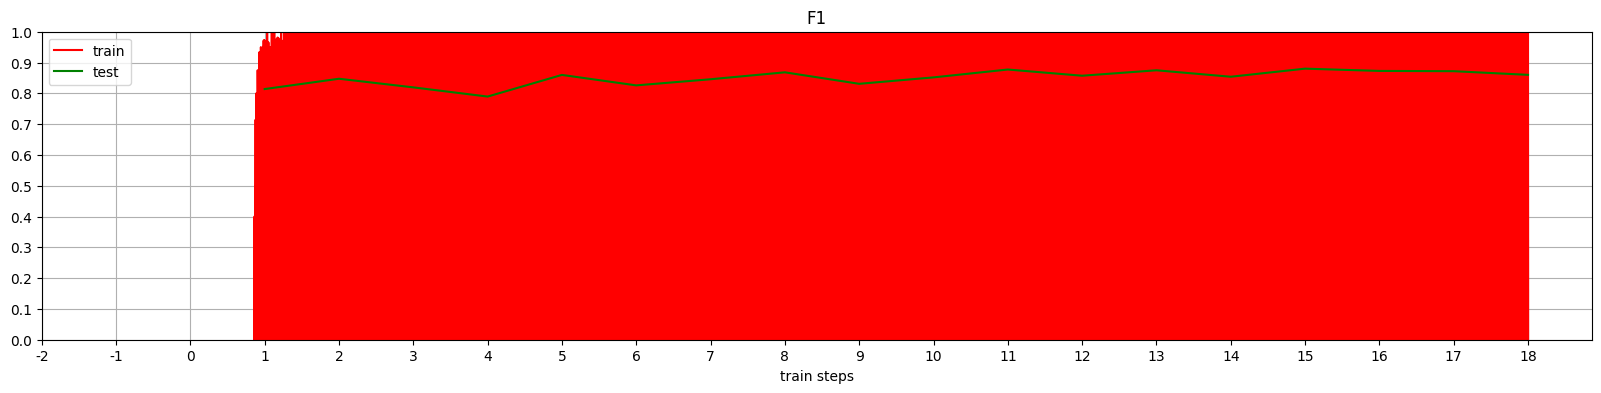

Epoch 18 AUC = 97.83%
Epoch 18 accuracy = 95.39%
Epoch 18 F1 = 86.00%
Epoch 19 of 20


In [ ]:
val_auc_log, val_f1_log, val_acc_log, times, best_models = train(model, opt, 20)

In [ ]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f}".format(np.mean(times)))

In [ ]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 'best_12_layer_alpha_model.pt')